In [5]:
import pandas as pd

# Introduction

## COVID data

In [6]:
covid_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
covid_data.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


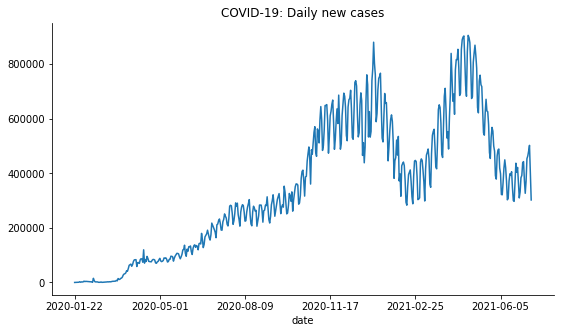

In [7]:
ax = covid_data[(covid_data['location']=='World')].plot(x='date', y='new_cases', title='COVID-19: Daily new cases', figsize=(9, 5))
ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#fig = ax.get_figure()
#fig.savefig('pictures/covid_world_daily.png')

# SARIMAX

## Moving Average

In [8]:
import math
import numpy as np

In [9]:
n = 300
sigma  = 2.0

df = pd.DataFrame({
    'Z': np.random.normal(loc=0.0, scale=sigma, size=n),
    'L': np.random.lognormal(mean=0.0, sigma=sigma, size=n),
})
df['L0'] = df['L'] - df['L'].mean() # math.exp(sigma**2/2)
df['logL'] = df['L'].apply(math.log)

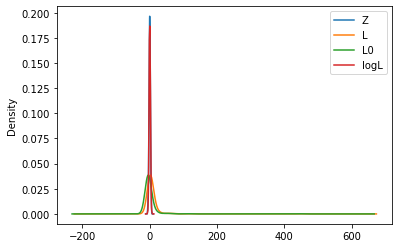

In [10]:
df.plot.kde()

In [11]:
df.describe()

,Z,L,L0,logL
count,300.000000,300.000000,3.000000e+02,300.000000
mean,-0.076322,6.426285,-3.416526e-15,0.004739
std,2.009494,28.563850,2.856385e+01,1.939725
min,-6.064972,0.001667,-6.424618e+00,-6.396482
25%,-1.366952,0.244831,-6.181455e+00,-1.407199
50%,-0.122600,1.038621,-5.387664e+00,0.037888
75%,1.234303,4.200851,-2.225434e+00,1.435286
max,4.832036,448.770903,4.423446e+02,6.106513


In [12]:
def pretty_plot(series, title, name=None):
    ax=series.plot(title=title, figsize=(9, 5))
    #ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if name is not None:
        fig = ax.get_figure()
        fig.savefig(f'pictures/{name}.png')

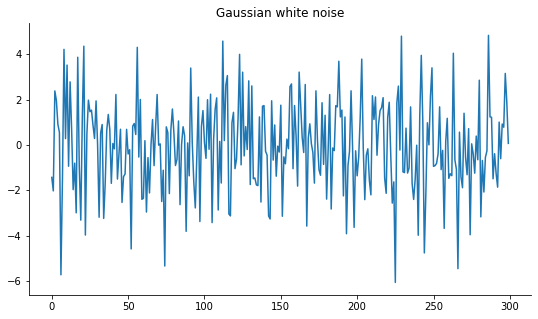

In [13]:
pretty_plot(df['Z'], title='Gaussian white noise')

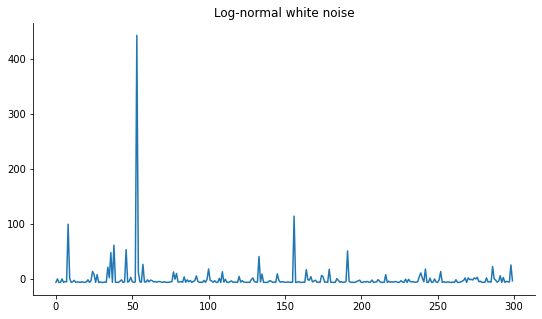

In [14]:
pretty_plot(df['L0'], title='Log-normal white noise')

In [15]:
# MA
beta_1 = 0.8
beta_2 = 0.3

df['MA(2)'] = df['Z'] + beta_1*df['Z'].shift(1) + beta_2*df['Z'].shift(2)
df['MA(1)'] = df['Z'] + beta_1*df['Z'].shift(1)

df['MA(2) L'] = df['L0'] + beta_1*df['L0'].shift(1) + beta_2*df['L0'].shift(2)
df['MA(1) L'] = df['L0'] + beta_1*df['L0'].shift(1)

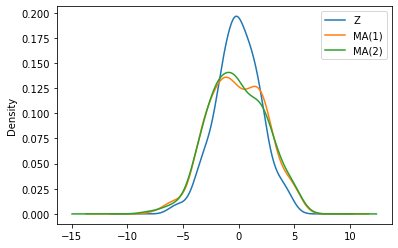

In [16]:
df[['Z', 'MA(1)', 'MA(2)']].plot.density()

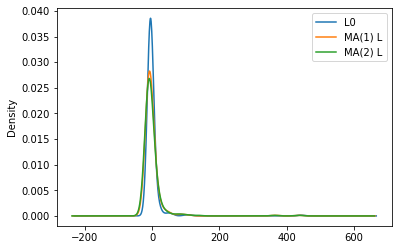

In [17]:
df[['L0', 'MA(1) L', 'MA(2) L']].plot.density()

In [18]:
from statsmodels.tsa.stattools import adfuller, kpss
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html

In [19]:
adfuller(df['MA(1)'].dropna(), regression='c')

(-10.04239226075932,
 1.4844611445417828e-17,
 3,
 295,
 {'1%': -3.452713099849546,
  '10%': -2.5720171933352485,
  '5%': -2.871387839457783},
 1189.0151617188549)

In [20]:
kpss(df['MA(1)'].dropna(), regression='c') #, nlags='auto')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.08158554744000383,
 0.1,
 16,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [21]:
adfuller(df['MA(1) L'].dropna(), regression='c')

(-8.219412868223387,
 6.490430805511434e-13,
 3,
 295,
 {'1%': -3.452713099849546,
  '10%': -2.5720171933352485,
  '5%': -2.871387839457783},
 2710.953471861205)

## Autocorrelation function

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html

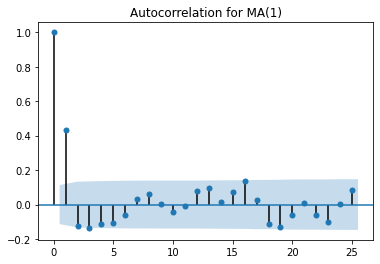

In [23]:
plot_acf(df['MA(1)'].dropna(), title='Autocorrelation for MA(1)');

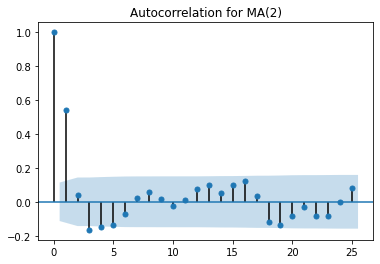

In [24]:
plot_acf(df['MA(2)'].dropna(), title='Autocorrelation for MA(2)');

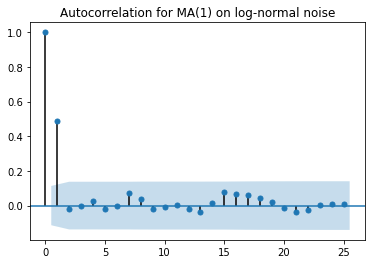

In [25]:
plot_acf(df['MA(1) L'].dropna(), title='Autocorrelation for MA(1) on log-normal noise');

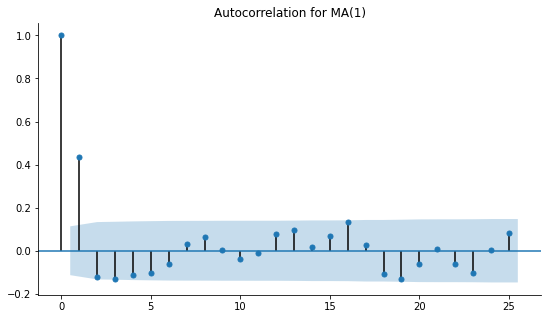

In [26]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(9,5))
plot_acf(df['MA(1)'].dropna(), ax=ax, title='Autocorrelation for MA(1)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('acf.png')

## AutoRegressive

In [27]:
!pip install --upgrade statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [28]:
from statsmodels.tsa.arima_process import arma_generate_sample

In [38]:
df['AR(1)'] = arma_generate_sample(ar=[1, 0.9], ma=[1], nsample=n, scale=sigma)

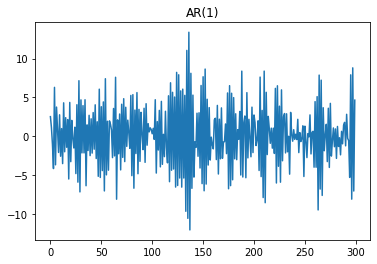

In [39]:
df['AR(1)'].plot(title='AR(1)')

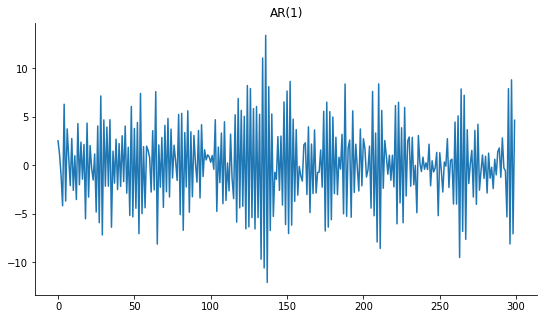

In [42]:
pretty_plot(df['AR(1)'], title='AR(1)')
plt.savefig('ar1.png')

## Partial Autocorrelation Function

In [43]:
from statsmodels.tsa.stattools import pacf
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
from statsmodels.graphics.tsaplots import plot_pacf

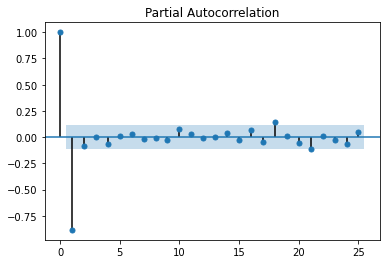

In [44]:
plot_pacf(df['AR(1)'].dropna());

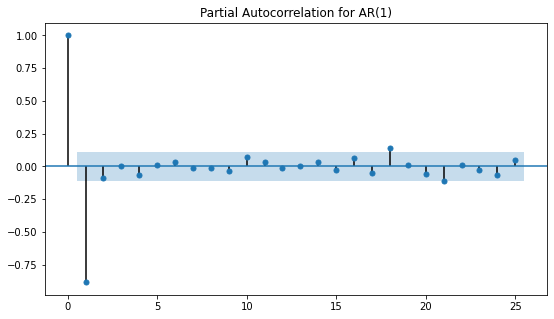

In [46]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(df['AR(1)'].dropna(), ax=ax, title='Partial Autocorrelation for AR(1)')
plt.savefig('pacf.png')

## Parameters estimation

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:
model = SARIMAX(df['MA(1)'], exog=None, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ma.L1     0.785974
sigma2    4.042235
dtype: float64

In [49]:
model = SARIMAX(df['MA(1) L'], exog=None, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ma.L1       0.797972
sigma2    815.739543
dtype: float64

In [50]:
#math.exp(sigma**2-1) * math.exp(sigma**2)

In [51]:
model = SARIMAX(df['AR(1)'], exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ar.L1    -0.883000
sigma2    4.094517
dtype: float64

In [53]:
from statsmodels.tsa.arima_process import arma_generate_sample

In [54]:
df['AR(4)'] = arma_generate_sample(ar=[1, 0.8, 0.5, 0.3, 0.1], ma=[1], nsample=n, scale=sigma)
model = SARIMAX(df['AR(4)'], exog=None, order=(4, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ar.L1    -0.758873
ar.L2    -0.441304
ar.L3    -0.323665
ar.L4    -0.025283
sigma2    3.839067
dtype: float64

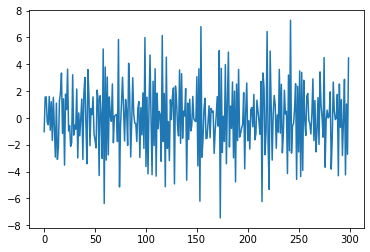

In [55]:
df['AR(4)'].plot()

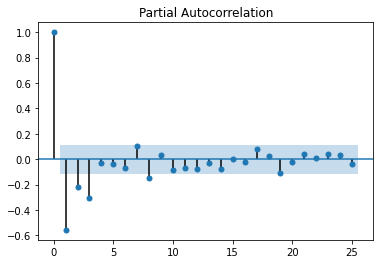

In [56]:
plot_pacf(df['AR(4)'].dropna());

In [86]:
#df = pd.DataFrame()
df['AR(1) L'] = arma_generate_sample(ar=[1, 0.8], ma=[1], nsample=n, distrvs=np.random.lognormal, scale=sigma)

In [58]:
df['AR(4) L'] = arma_generate_sample(ar=[1, 0.8, 0.5, 0.3, 0.1], ma=[1], nsample=n, distrvs=np.random.lognormal, scale=sigma)
model = SARIMAX(df['AR(4) L'], exog=None, order=(4, 0, 0), seasonal_order=(0, 0, 0, 0), trend=[1])
model_fit = model.fit()
model_fit.params

intercept     3.393520
ar.L1        -0.849709
ar.L2        -0.557872
ar.L3        -0.251360
ar.L4        -0.026856
sigma2       19.416464
dtype: float64

In [59]:
df['AR(4) L'].std()

5.8720152156344945

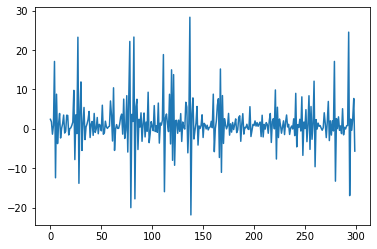

In [60]:
df['AR(4) L'].plot()

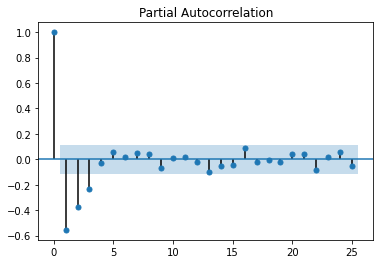

In [61]:
plot_pacf(df['AR(4) L'].dropna());

## Checking various distributions

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller

In [ ]:
sigma = 2
normal = arma_generate_sample(ar=[1]+[0.8, 0.5, 0.3, 0.1], ma=[1], nsample=1000, scale=sigma)

In [ ]:
#pd.Series(sigma*pareto(size=1000)).hist()

<AxesSubplot:>

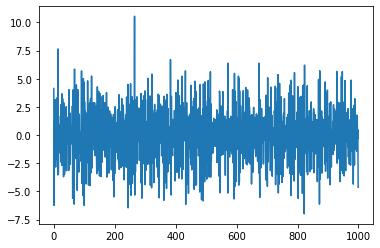

In [ ]:
pd.Series(normal).plot()

In [ ]:
from statsmodels.tsa.stattools import kpss

In [ ]:
def estimate_params(mc, dist=np.random.standard_normal, ar_params=[0.8, 0.5, 0.3, 0.1], n=300, sigma=sigma):
    np.random.seed(mc)
    normal = arma_generate_sample(ar=[1] + ar_params, distrvs=dist, ma=[1], nsample=n, scale=sigma)
    
    p = pd.Series(abs(pacf(normal, nlags=10)))
    m = p.rolling(5, min_periods=1).mean()

    model = SARIMAX(normal, exog=None, order=(4, 0, 0), seasonal_order=(0, 0, 0, 0), trend=[1])
    model_fit = model.fit()
    return pd.DataFrame({'n': n, 'dist': dist.__name__, 'params': ar_params, 'est_params': -model_fit.params[1:-1], 
                         'coeff': model_fit.params[1], 'sigma2':sigma*sigma, 'est_sigma2': model_fit.params[-1], 
                         'est_p': m[m < (m.shift(1)*0.7)].index.min() - 1, 
                         'pacf': p[1:5],
                         'stationary_ct': adfuller(normal, regression='ct')[1] < 0.05,
                         'stationary_ct_kpss': kpss(normal, regression='ct', nlags="auto")[1] > 0.05,
                         'stationary_c': adfuller(normal, regression='c')[1] < 0.05
                        })

In [ ]:
estimate_params(1)

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,n,dist,params,est_params,coeff,sigma2,est_sigma2,est_p,pacf,stationary_ct,stationary_ct_kpss,stationary_c
1,300,standard_normal,0.8,0.857079,-0.857079,4,3.527773,4,0.585105,True,True,True
2,300,standard_normal,0.5,0.544178,-0.857079,4,3.527773,4,0.281198,True,True,True
3,300,standard_normal,0.3,0.375592,-0.857079,4,3.527773,4,0.294503,True,True,True
4,300,standard_normal,0.1,0.105446,-0.857079,4,3.527773,4,0.111171,True,True,True


In [ ]:
def pareto(size):
    return np.random.pareto(10, size)

In [ ]:
dist_vec = [np.random.standard_normal, np.random.exponential, np.random.poisson, np.random.lognormal, pareto]
n_vec = [24, 48, 72, 100, 200, 300, 500, 1000]
mc_vec = range(100)

In [ ]:
# TODO check stationarity - wrongly assumed they are not statinary
# guessing parameter on pacf
res_array = []
for dist in dist_vec:
    print(dist)
    for n in n_vec:
        for mc in mc_vec:
            res_one = estimate_params(mc=mc, dist=dist, n=n)
            res_one['mc'] = mc
            res_array.append(res_one)

<built-in method standard_normal of numpy.random.mtrand.RandomState object at 0x000002730762FB40>


c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

<built-in method exponential of numpy.random.mtrand.RandomState object at 0x000002730762FB40>


c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

<built-in method poisson of numpy.random.mtrand.RandomState object at 0x000002730762FB40>


c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWar

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWar

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

<built-in method lognormal of numpy.random.mtrand.RandomState object at 0x000002730762FB40>


c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWar

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

<function pareto at 0x00000273204F6820>


c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of th

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of th

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning

In [ ]:
res = pd.concat(res_array)

In [ ]:
# spr lasya
res.to_csv('sim_results.csv')

In [ ]:
res['error'] = res['est_params'] - res['params']
res['abs_error'] = res['error'].abs()

In [ ]:
res['stationary_ct'].value_counts()

True     14524
False     1476
Name: stationary_ct, dtype: int64

In [ ]:
res['stationary_ct_kpss'].value_counts()

True     10772
False     5228
Name: stationary_ct_kpss, dtype: int64

In [ ]:
res['stationary_c'].value_counts()

True     15012
False      988
Name: stationary_c, dtype: int64

In [ ]:
res[~res['stationary_ct']]['dist'].value_counts()

standard_normal    320
exponential        304
lognormal          292
poisson            288
pareto             272
Name: dist, dtype: int64

In [ ]:
res['est_p'].value_counts()

4.0    14600
0.0      664
1.0      156
5.0       68
7.0       32
9.0       24
6.0       16
8.0        8
Name: est_p, dtype: int64

In [ ]:
res[res['est_p']!=4]['dist'].value_counts()

poisson            32
lognormal          28
pareto             16
exponential        16
standard_normal    12
Name: dist, dtype: int64

In [ ]:
res.head()

,n,dist,params,est_params,coeff,sigma2,est_sigma2,est_p,pacf,stationary_ct,stationary_ct_kpss,stationary_c,mc,error,abs_error
1,24,standard_normal,0.8,0.665573,-0.665573,4,3.779627,4.0,0.437085,False,False,True,0,-0.134427,0.134427
2,24,standard_normal,0.5,0.469032,-0.665573,4,3.779627,4.0,0.426234,False,False,True,0,-0.030968,0.030968
3,24,standard_normal,0.3,0.047007,-0.665573,4,3.779627,4.0,0.033200,False,False,True,0,-0.252993,0.252993
4,24,standard_normal,0.1,0.099530,-0.665573,4,3.779627,4.0,0.048680,False,False,True,0,-0.000470,0.000470
1,24,standard_normal,0.8,1.106003,-1.106003,4,2.881695,NaN,0.832783,True,False,True,1,0.306003,0.306003


In [ ]:
data_agg = res[['dist', 'n', 'abs_error']].groupby(['dist', 'n']).mean().reset_index()

In [ ]:
# TODO reset multiindex

<AxesSubplot:xlabel='n'>

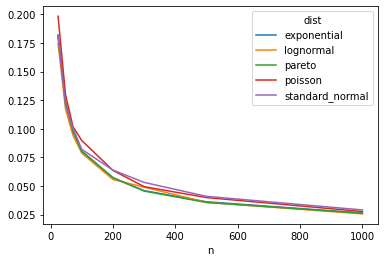

In [ ]:
results = pd.pivot_table(data=data_agg, values='abs_error', index='n', columns='dist')
results.plot()

## AutoRegressive Moving Average

In [63]:
df['ARMA(1,1)'] = df['AR(1)'] + df['MA(1)']  #arma_generate_sample(ar=[1, -0.9], ma=[1, 0.2], nsample=n, scale=sigma) 
#df['ARMA(1,1) L'] = df['AR(1) L'] + df['MA(1) L']

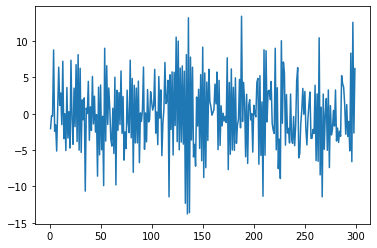

In [64]:
df['ARMA(1,1)'].plot()

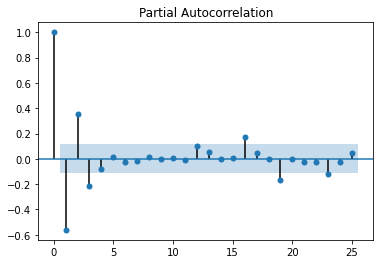

In [65]:
plot_pacf(df['ARMA(1,1)'].dropna());

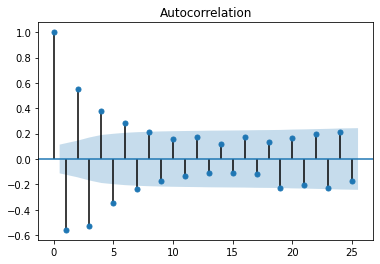

In [66]:
plot_acf(df['ARMA(1,1)'].dropna());

In [67]:
model = SARIMAX(df['ARMA(1,1)'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ar.L1     -0.899478
ma.L1      0.534195
sigma2    14.625945
dtype: float64

## AutoRegressive Integrated Moving Average

In [69]:
import matplotlib.pyplot as plt

In [70]:
df['t'] = range(df.shape[0])

In [71]:
df['ARIMA(1,1,1)'] = df['ARMA(1,1)'] + df['t']/5

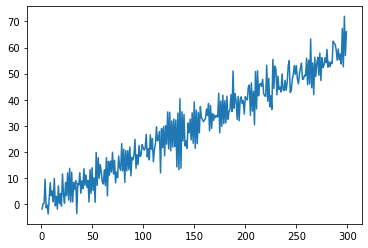

In [72]:
df['ARIMA(1,1,1)'].plot()

In [73]:
adfuller(df['ARIMA(1,1,1)'].dropna(), regression='ct')

(-10.04644854971878,
 1.8401406099304653e-15,
 3,
 295,
 {'1%': -3.9897903649837616,
  '10%': -3.1358607194990724,
  '5%': -3.425478311521626},
 1557.0248346956932)

In [74]:
kpss(df['ARIMA(1,1,1)'].dropna(), regression='c', nlags='auto')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(2.824227123222506,
 0.01,
 10,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [75]:
adfuller(df['ARIMA(1,1,1)'].diff(1).dropna(), regression='c')

(-9.111173233123884,
 3.3963736588160785e-15,
 14,
 283,
 {'1%': -3.453670163592738,
  '10%': -2.5722411158835796,
  '5%': -2.8718077069772248},
 1570.6462872833986)

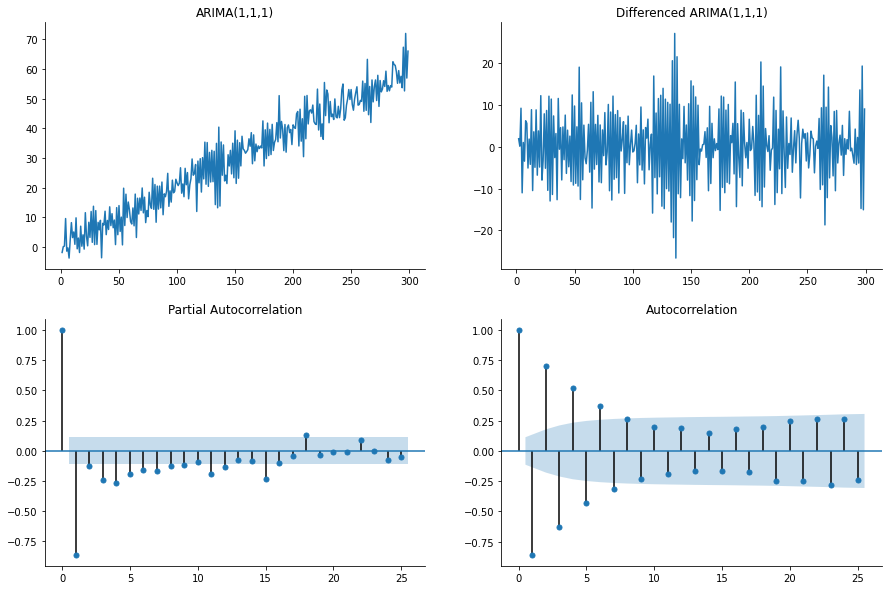

In [76]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
df['ARIMA(1,1,1)'].plot(title='ARIMA(1,1,1)', ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

df['ARIMA(1,1,1)'].diff(1).plot(ax=ax2, title='Differenced ARIMA(1,1,1)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plot_pacf(df['ARIMA(1,1,1)'].diff(1).dropna(), title='Partial Autocorrelation', ax=ax3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plot_acf(df['ARIMA(1,1,1)'].diff(1).dropna(), title='Autocorrelation', ax=ax4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#fig = ax.get_figure()
#fig.savefig('pictures/arima.png')

In [77]:
model = SARIMAX(df['ARIMA(1,1,1)'], exog=None, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), trend=[1])
model_fit = model.fit()
model_fit.params

intercept     0.309754
ar.L1        -0.560747
ma.L1        -0.999925
sigma2       16.972366
dtype: float64

## Seasonal AutoRegressive Moving Average

In [87]:
df['cos'] = df['t'].apply(lambda x: 10*math.cos(x / 12 * 2 * math.pi) )
df['SARIMA (0,1,1) (0,1,0)12'] = df['cos'] + df['MA(1)'] + df['t']*df['t']/1000
df['SARIMA (0,1,1) (0,1,0)12 L'] = 5*df['cos'] + df['AR(1) L'] + df['t']*df['t']/100

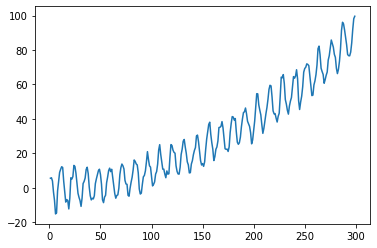

In [80]:
df['SARIMA (0,1,1) (0,1,0)12'].plot()

In [81]:
#df['SARIMA (0,1,1) (0,1,0)12 L'].plot()

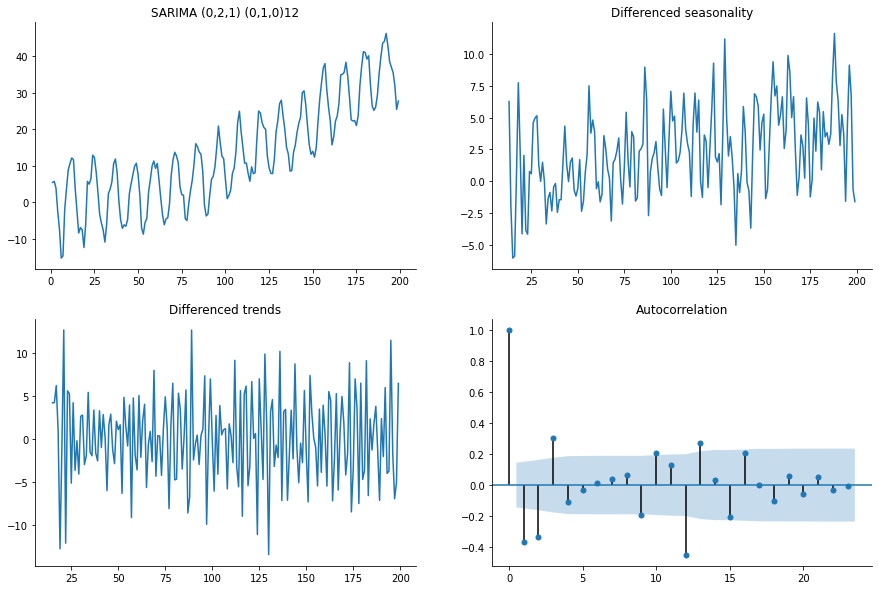

In [82]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].plot(title='SARIMA (0,2,1) (0,1,0)12', ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].diff(12).plot(ax=ax2, title='Differenced seasonality')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].diff(12).diff(1).diff(1).plot(ax=ax3, title='Differenced trends')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plot_acf(df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].diff(12).diff(1).diff(1).dropna(), title='Autocorrelation', ax=ax4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#fig = ax.get_figure()
#fig.savefig('pictures/sarima.png')

In [83]:
model = SARIMAX(df['SARIMA (0,1,1) (0,1,0)12'], exog=None, order=(0,2,1), seasonal_order=(0, 1, 0, 12), trend=None)
model_fit = model.fit()
model_fit.params

ma.L1     -0.999680
sigma2    13.365322
dtype: float64

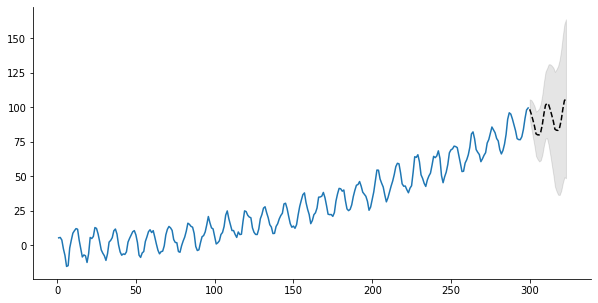

In [85]:
fcst = model_fit.get_forecast(2*12).summary_frame()

fig, ax = plt.subplots(figsize=(10, 5))

df['SARIMA (0,1,1) (0,1,0)12'].plot(ax=ax)

fcst['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcst.index, fcst['mean_ci_lower'], fcst['mean_ci_upper'], color='k', alpha=0.1);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig = ax.get_figure()
fig.savefig(f'prediction_intervals.png')

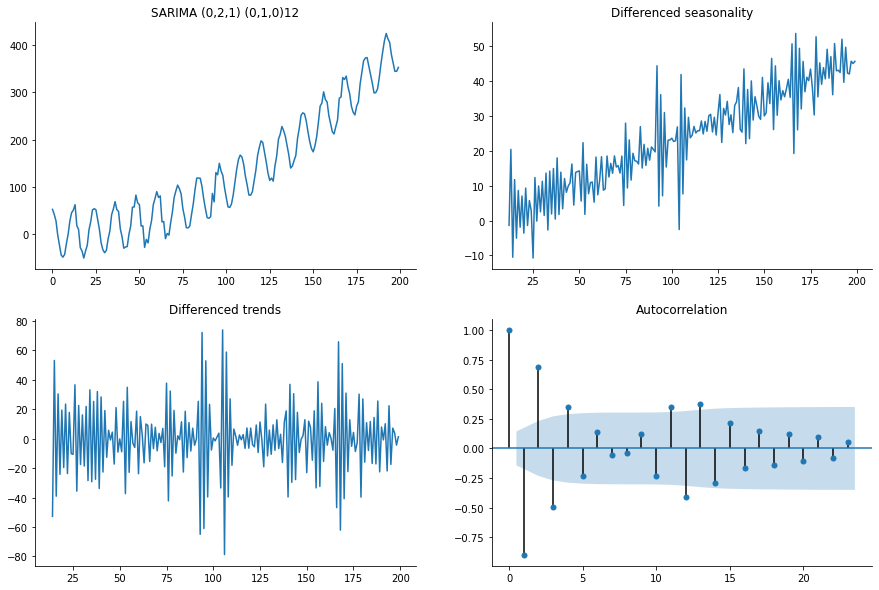

In [88]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].plot(title='SARIMA (0,2,1) (0,1,0)12', ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].diff(12).plot(ax=ax2, title='Differenced seasonality')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].diff(12).diff(1).diff(1).plot(ax=ax3, title='Differenced trends')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plot_acf(df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].diff(12).diff(1).diff(1).dropna(), title='Autocorrelation', ax=ax4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#fig = ax.get_figure()
#fig.savefig('pictures/sarima.png')

In [89]:
model = SARIMAX(df['SARIMA (0,1,1) (0,1,0)12 L'], exog=None, order=(1,2,0), seasonal_order=(0, 1, 0, 12), trend=None)
model_fit = model.fit()
model_fit.params
#model_fit.get_prediction(start=dataset.index[0], end=dataset.index[10]).summary_frame()

ar.L1      -0.907504
sigma2    234.442087
dtype: float64

"SARIMA (0,1,1) (0,1,0)12 L",mean,mean_se,mean_ci_lower,mean_ci_upper
99793,6.081770e+07,4.671158e+11,-9.154693e+11,9.155909e+11
99794,6.081890e+07,4.671275e+11,-9.154923e+11,9.156139e+11
99795,6.082009e+07,4.671393e+11,-9.155153e+11,9.156369e+11
99796,6.082129e+07,4.671510e+11,-9.155383e+11,9.156600e+11
99797,6.082247e+07,4.671627e+11,-9.155613e+11,9.156830e+11
99798,6.082370e+07,4.671745e+11,-9.155843e+11,9.157060e+11
99799,6.082491e+07,4.671862e+11,-9.156073e+11,9.157290e+11
99800,6.082615e+07,4.671979e+11,-9.156303e+11,9.157520e+11
99801,6.082739e+07,4.672097e+11,-9.156533e+11,9.157750e+11
99802,6.082864e+07,4.672214e+11,-9.156763e+11,9.157980e+11


In [ ]:
#!pip install pmdarima

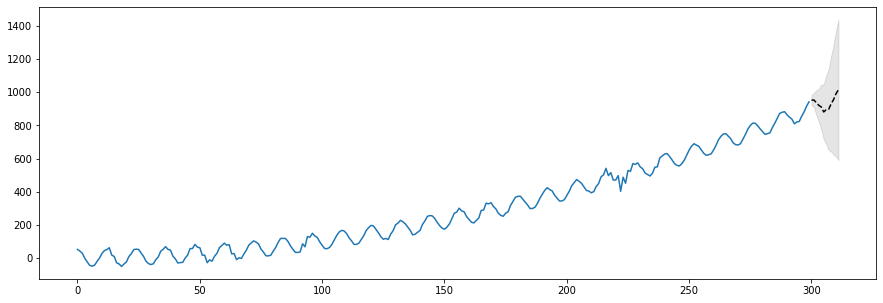

In [90]:
fcst = model_fit.get_forecast(12).summary_frame()

fig, ax = plt.subplots(figsize=(15, 5))

df['SARIMA (0,1,1) (0,1,0)12 L'].plot(ax=ax)

fcst['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcst.index, fcst['mean_ci_lower'], fcst['mean_ci_upper'], color='k', alpha=0.1);

## Fitting best model

In [93]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     |████████████████████████████████| 1.5MB 29.7MB/s 


In [94]:
model = auto_arima(df['MA(1)'].dropna())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -627.832
Date:                Mon, 12 Jul 2021   AIC                           1267.663
Time:                        06:13:50   BIC                           1289.866
Sample:                             0   HQIC                          1276.550
                                - 299                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7542      0.060     29.240      0.000       1.637       1.872
ar.L2         -0.8927      0.057    -15.715      0.000      -1.004      -0.781
ma.L1         -1.0337      0.066    -15.708      0.000      -1.163      -0.905
ma.L2         -0.5081      0.081     -6.271      0.000      -0.667      -0.349
ma.L3          0.7428      0.055     13.392      0.000       0.634       0.852
sigma2         3.8835      0.308     12.599      0.000       3.279       4.488
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.99   Prob(JB):                         0.37
Heteroskedasticity (H):               1.04   Skew:                            -0.19
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
model = auto_arima(df['AR(1)'].dropna())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -637.886
Date:                Mon, 12 Jul 2021   AIC                           1279.772
Time:                        06:13:52   BIC                           1287.179
Sample:                             0   HQIC                          1282.736
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8830      0.028    -31.396      0.000      -0.938      -0.828
sigma2         4.0945      0.323     12.672      0.000       3.461       4.728
===================================================================================
Ljung-Box (L1) (Q):                   1.58   Jarque-Bera (JB):                 4.42
Prob(Q):                              0.21   Prob(JB):                         0.11
Heteroskedasticity (H):               1.03   Skew:                            -0.28
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

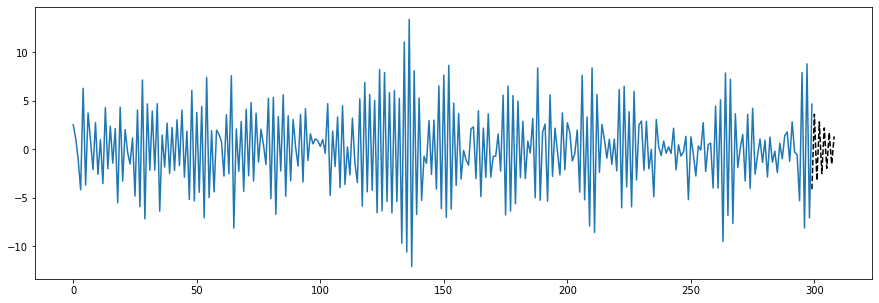

In [96]:
fig, ax = plt.subplots(figsize=(15, 5))

df['AR(1)'].plot(ax=ax)

pd.Series(model.predict(), index=range(df.index.max(), df.index.max()+ len(model.predict()) )).plot(ax=ax, style='k--')

# COVID dat

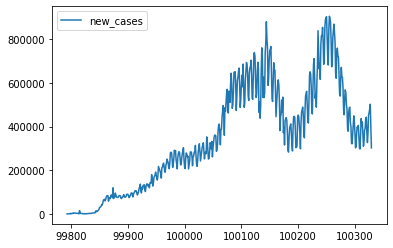

In [100]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [112]:
model = SARIMAX(dataset[target], exog=None, order=(1,2,0), seasonal_order=(0, 1, 0, 12), trend=None)
model_fit = model.fit()
model_fit.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ar.L1    -2.265171e-01
sigma2    1.001555e+10
dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


new_cases,mean,mean_se,mean_ci_lower,mean_ci_upper
99793,-5.956820e+13,4.720016e+15,-9.310629e+15,9.191493e+15
99794,-5.956940e+13,4.720135e+15,-9.310863e+15,9.191725e+15
99795,-5.957060e+13,4.720254e+15,-9.311098e+15,9.191956e+15
99796,-5.957180e+13,4.720372e+15,-9.311332e+15,9.192188e+15
99797,-5.957300e+13,4.720491e+15,-9.311566e+15,9.192420e+15
99798,-5.957420e+13,4.720610e+15,-9.311800e+15,9.192652e+15
99799,-5.957540e+13,4.720729e+15,-9.312035e+15,9.192884e+15
99800,-5.957660e+13,4.720848e+15,-9.312269e+15,9.193116e+15
99801,-5.957780e+13,4.720967e+15,-9.312503e+15,9.193347e+15
99802,-5.957900e+13,4.721086e+15,-9.312737e+15,9.193579e+15


In [135]:
from sklearn.base import BaseEstimator, RegressorMixin


class SARIMARegressor(BaseEstimator, RegressorMixin):
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

    def __init__(self, order=(1,2,0), seasonal_order=(0, 1, 0, 12)):
        self.order = order
        self.seasonal_order = seasonal_order

        self.model = None
        self.predictions= None
        self.feature_importances_ = [0]

    def fit(self, X, y):
        model = SARIMAX(y, exog=None, order=self.order, seasonal_order=self.seasonal_order, trend=None)
        model_fit = model.fit()
        self.model = model_fit
        return self

    def predict(self, X):
        X = np.ndarray.flatten(X)
        predictions = self.model.get_prediction(start=min(X), end=max(X)).summary_frame()
        self.predictions = predictions[['mean_ci_lower', 'mean_ci_upper']].rename(columns={'mean_ci_lower': 'pi_lower', 'mean_ci_upper': 'pi_upper'})
        return predictions['mean'].values

    def get_params(self, deep=True):
        return {"order": self.order, 'seasonal_order': self.seasonal_order}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [136]:
sr = SARIMARegressor()
sr.fit(dataset[target], dataset[target])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMARegressor(order=(1, 2, 0), seasonal_order=(0, 1, 0, 12))

In [137]:
#!pip install sklearn-ts==0.0.4

In [138]:
from sklearn_ts.validator import check_model

Grid search
Fitting to train
Plot


{'regressor__seasonal_order': (0, 1, 0, 7)}

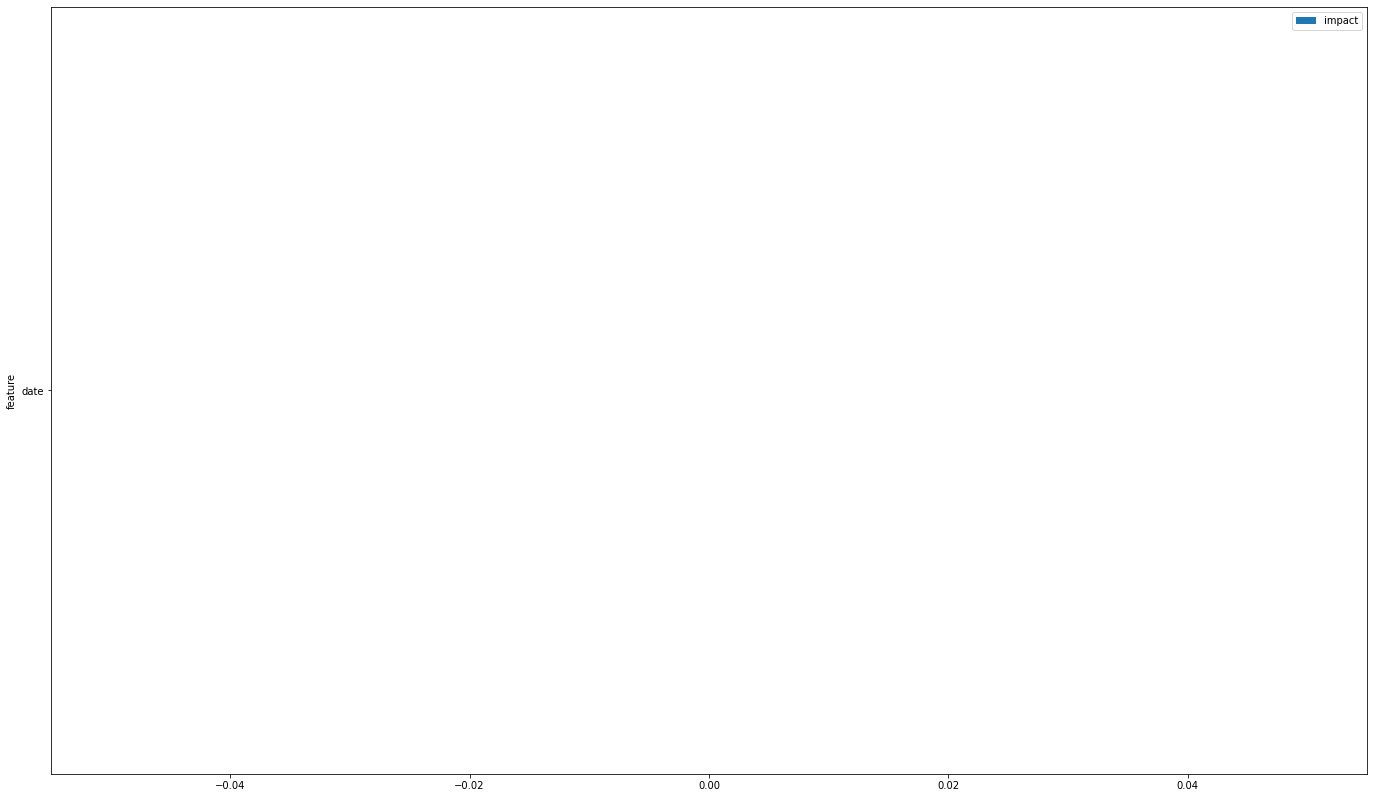

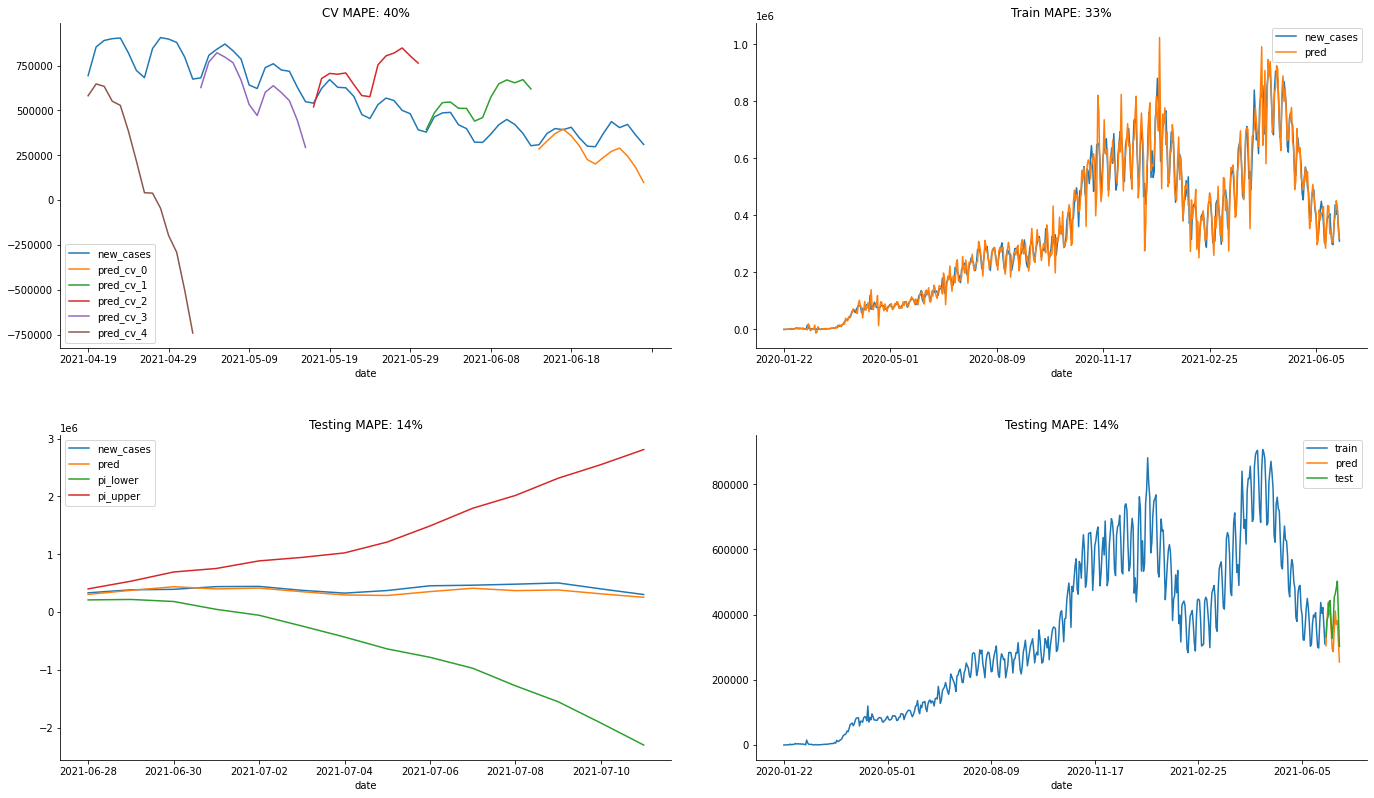

In [139]:
import warnings
warnings.filterwarnings('ignore')

params = {'seasonal_order': [(0, 1, 0, 7)]}
regressor = SARIMARegressor()

dataset.index = dataset['date']

results = check_model(regressor, params, dataset)
results['best_params']

## Sktime

In [ ]:
from sktime.forecasting.arima import AutoARIMA

In [ ]:
forecaster = AutoARIMA(suppress_warnings=True,sp=12)
forecaster.fit(df['SARIMA (0,1,1) (0,1,0)12'].dropna())

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,2)(1,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


In [ ]:
forecaster.get_fitted_params()

{'ar.L1': 0.5306901311668675,
 'ar.L2': -0.30678824365508556,
 'ma.L1': -0.7556692257614895,
 'ar.S.L12': 0.9990512055998588,
 'ma.S.L12': -1.0231098363828237,
 'ma.S.L24': 0.12464814523513877,
 'sigma2': 5.014501344655652}

In [ ]:
?AutoARIMA

In [ ]:
y_pred = forecaster.predict(fh=list(range(1, 4*12 +1)), return_pred_int=True, alpha=0.05)
y_pred[1]['mean'] = y_pred[0]
y_pred = y_pred[1]
y_pred.head()

,lower,upper,mean
300,95.766263,104.546554,100.156409
301,92.738107,103.846525,98.292316
302,88.033898,99.556805,93.795352
303,82.996291,94.641447,88.818869
304,78.522334,90.355091,84.438713


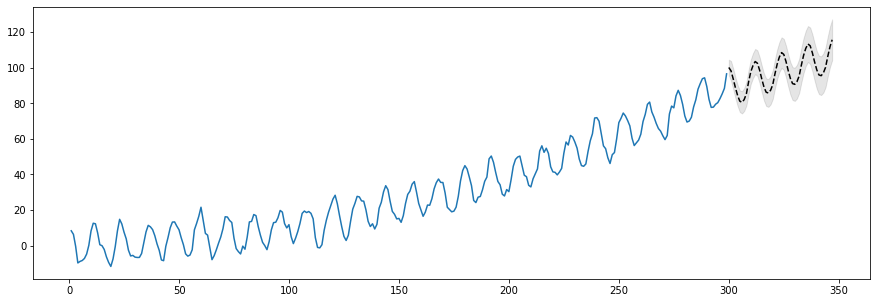

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

df['SARIMA (0,1,1) (0,1,0)12'].plot(ax=ax)

y_pred['mean'].plot(ax=ax, style='k--')
ax.fill_between(y_pred.index, y_pred['lower'], y_pred['upper'], color='k', alpha=0.1)